# Analyzing Timelags with a Random Forest Classifier

In [71]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sunpy.map import Map
import astropy.units as u
from astropy.coordinates import SkyCoord
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In this notebook, we want to analyze our observed timelags using our modeled timelags for our three primary heating scenarios along with a multi-classification classifier, e.g. random forest.

We'll do this in a few stages:
* Import simulation data
* Clean and prep simulation data
* Train a model on simulation data
* Import, clean, prep observed data
* Classify observed data based on above model
* Create map of heating frequencies from our classified observed data

## Import and Prep Simulation Data

First, let's import the simulation data.

In [2]:
channel_pairs = [(94,335), (94,171), (335,211), (335,171), (193,171), (171,131)]

In [3]:
frequencies = ['high', 'intermediate', 'low']

In [4]:
filename = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{frequency}_frequency/nei/timelags/{type}_{c0}_{c1}.fits'

In [5]:
timelag,correlation = {}, {}
for f in frequencies:
    timelag[f'{f}'] = {}
    correlation[f'{f}'] = {}
    for p in channel_pairs:
        timelag[f'{f}']['{}_{}'.format(*p)] = Map(filename.format(frequency=f, type='timelag', c0=p[0], c1=p[1]))
        correlation[f'{f}']['{}_{}'.format(*p)] = Map(filename.format(frequency=f, type='correlation', c0=p[0], c1=p[1]))

Now that we've got the data, we need to transform it into a format that the model framework, scikit-learn, can understand.

We need a matrix $\mathbf{X}$ with dimensions $N_{samples}\times N_{features}$. In our case, $N_{samples}$ is just the total number of pixels and $N_{features}$ is the number of channel pairs, i.e. $N_{features}=6$. Each entry in $\mathbf{X}$ will give the (scaled) timelag value for that particular channel pair at a single pixel. Additionally, we need another matrix $\mathbf{Y}$ which gives the heating classification for each pixel. We can encode the heating frequency in the following way,

| Heating Frequency | Encoding |
|-------------------|----------|
| Low | 2 |
| Intermediate | 1 |
| High | 0 |

To summarize, we need to construct two matrices from our imported simulation data,

$$
\mathbf{X} \in \mathbb{R}^{N_{samples}\times N_{features}} \\ 
\mathbf{Y} \in \mathbb{R}^{N_{samples}}
$$

Furthermore, we want to filter our timelag values so as to exclude those pixels with low correlations.

Now, we are ready to create $\mathbf{X}$ and $\mathbf{Y}$.

In [6]:
X = None
Y = None
correlation_threshold = 500.0
for f in frequencies:
    X_tmp = None
    # Find the indices where all channel pairs have an acceptable correlation
    acceptable = np.all(np.stack([correlation[f]['{}_{}'.format(*p)].data for p in channel_pairs], axis=2) > correlation_threshold,axis=2)
    i_accept = np.where(acceptable)
    for p in channel_pairs:
        # Read in timelags and correlations
        tmp_tl = timelag[f]['{}_{}'.format(*p)].data
        # Only keep those timelags with sufficiently high correlations
        tmp_tl = tmp_tl[i_accept].flatten()
        # Stack along columns for different channel pairs
        X_tmp = tmp_tl.copy()[:,np.newaxis] if X_tmp is None else np.hstack([X_tmp, tmp_tl[:, np.newaxis]])
    # Stack along rows for different frequencies
    X = X_tmp.copy() if X is None else np.vstack([X, X_tmp])
    Y_tmp = np.array(X_tmp.shape[0]*[f])
    Y = Y_tmp.copy() if Y is None else np.concatenate([Y, Y_tmp])

We need to "encode" $\mathbf{Y}$. The first step is to go from our string label ("high", "intermediate", "low) to a numerical label (0, 1, 2). The second step is to encode our single category (heating frequency) as either on/off in three different categories. Notice that this means that $\mathbf{Y}$ now has dimensions
$\mathbf{Y}\in\mathbb{R}^{N_{samples}\times~3}$ since we our heating frequency can take on three different possible values.

In [7]:
le = LabelEncoder()
le.fit(['high','intermediate','low'])
Y_encoded = le.transform(Y)

Next, we need to scale our data. scikit-learn provides convenient machinery for doing this. Notice that we do not scale $\mathbf{Y}$ as it is a categorical variable.

In [8]:
X_scaled = scale(X, axis=0, with_mean=True, with_std=True,)

Finally, we want to split our inputs into training and test sets in order to properly assess our model performance.

In [9]:
X_train, X_test, Y_train_flat, Y_test_flat = train_test_split(X_scaled, Y_encoded, test_size=0.33)

Encade after splitting because some classifiers require flattened $\mathbf{Y}$ while others need it to be multidimensional.

In [10]:
ohe = OneHotEncoder()
ohe.fit([[0],[1],[2]])
Y_train = ohe.transform(Y_train_flat.reshape(Y_train_flat.shape[0],1)).toarray()
Y_test = ohe.transform(Y_test_flat.reshape(Y_test_flat.shape[0],1)).toarray()

## Import and Prep Observational Data
Our observational data import and prep process is essentially the same as that of the simulation data. Here, we also want to save the pixel locations of all the timelag values so that we can reconstruct the map later on.

**NOTE:** Ideally, we should also probably limit the pixels to those aligned with the part of the AR we actually simulation. This can be done getting all of the loop coordinates and then transforming them to pixel coordinates. However, setting a threshold on the correlation mostly takes care of this anyway.

In [11]:
filename = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/{type}_{c0}_{c1}.fits'
timelag_obs = {}
correlation_obs = {}
for p in channel_pairs:
    timelag_obs['{}_{}'.format(*p)] = Map(filename.format(type='timelag', c0=p[0], c1=p[1]))
    correlation_obs['{}_{}'.format(*p)] = Map(filename.format(type='correlation', c0=p[0], c1=p[1]))

In [12]:
X_observation = None
# Find the indices where all channel pairs have an acceptable correlation
acceptable = np.all(np.stack([correlation_obs['{}_{}'.format(*p)].data for p in channel_pairs], axis=2) > correlation_threshold,axis=2)
i_accept_obs = np.where(acceptable)
for p in channel_pairs:
    # Read in timelags and correlations
    tmp_tl = timelag_obs['{}_{}'.format(*p)].data
    # Only keep those timelags with sufficiently high correlations
    tmp_tl = tmp_tl[i_accept_obs].flatten()
    # Stack along columns for different channel pairs
    X_observation = tmp_tl.copy()[:,np.newaxis] if X_observation is None else np.hstack([X_observation, tmp_tl[:, np.newaxis]])

In [13]:
X_observation_scaled = scale(X_observation, axis=0, with_mean=True, with_std=True)

## Training and Assessing the Models
We've prepped our data appropriately and we're finally ready to train our models and assess their performance. We'll also apply each model to our observational data.

### Decision Tree

In [14]:
clf = DecisionTreeClassifier(criterion='entropy')

In [15]:
clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
clf.score(X_test,Y_test)

0.8467623822708759

### Random Forest

In [42]:
clf = RandomForestClassifier(n_estimators=30,criterion='entropy',n_jobs=-1)

In [43]:
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
clf.score(X_test,Y_test)

0.8723340567237896

In [45]:
Y_observation = clf.predict(X_observation_scaled)

In [46]:
Y_observation_invert = np.ones(Y_observation.shape[:1])*np.nan
Y_observation_invert[np.where(Y_observation[:,0] == 1)] = 0.
Y_observation_invert[np.where(Y_observation[:,1] == 1)] = 1.
Y_observation_invert[np.where(Y_observation[:,2] == 1)] = 2.

In [47]:
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_invert
frequency_map_random_forest = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)

In [48]:
# Not sure why I get no prediction for some results
np.where(np.isnan(Y_observation_invert))[0].shape

(25592,)

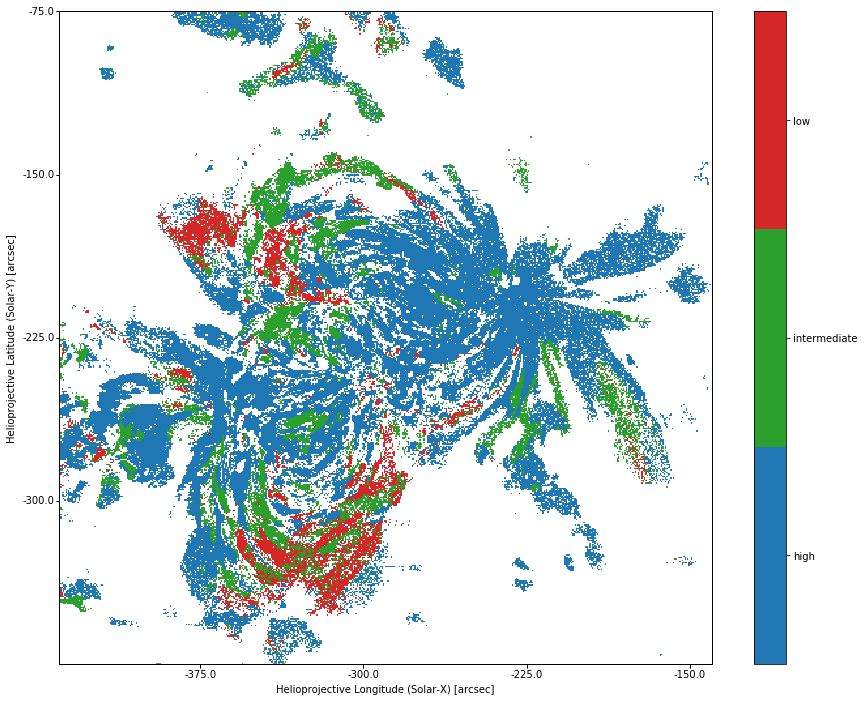

In [79]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca(projection=frequency_map_random_forest)
im = frequency_map_random_forest.plot(
    axes=ax,title=False,
    cmap=matplotlib.colors.ListedColormap(['C0','C2','C3'],N=3),
    vmin=-0.5,vmax=2.5)
fig.colorbar(im, ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),)
ax.grid(alpha=0)

### Adaboost

In [33]:
clf = AdaBoostClassifier(
    DecisionTreeClassifier(),
    learning_rate=1,
    n_estimators=600,
)

In [34]:
clf.fit(X_train, Y_train_flat)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=600, random_state=None)

In [35]:
clf.score(X_test,Y_test_flat)

0.9027057653863012

In [36]:
Y_observation = clf.predict(X_observation_scaled)

In [40]:
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation
frequency_map_adaboost = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)

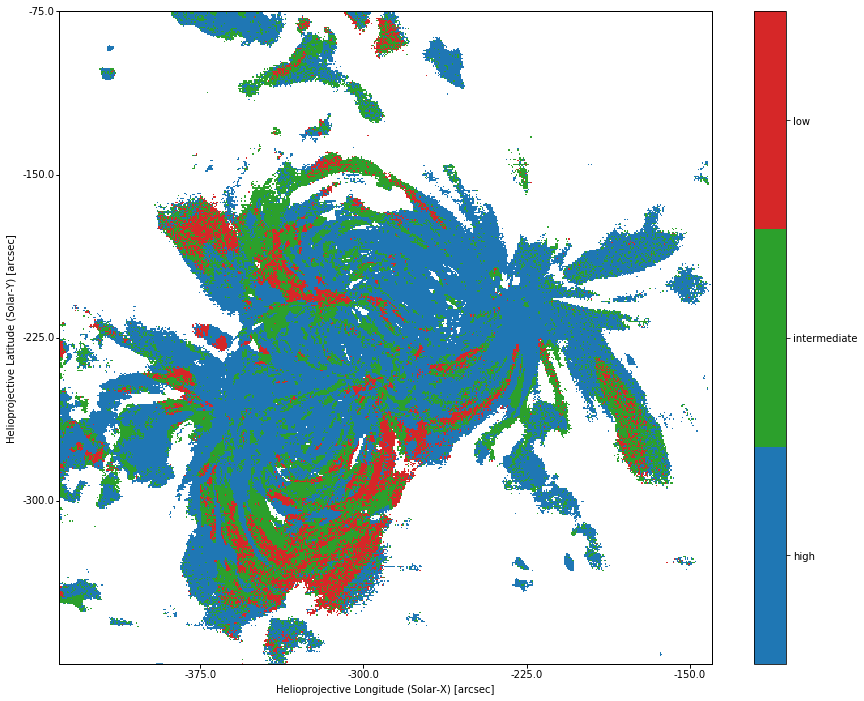

In [80]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca(projection=frequency_map_adaboost)
im = frequency_map_adaboost.plot(
    axes=ax,title=False,
    cmap=matplotlib.colors.ListedColormap(['C0','C2','C3'],N=3),
    vmin=-0.5,vmax=2.5)
fig.colorbar(im, ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),)
ax.grid(alpha=0)

### $K$ Nearest Neighbors 

In [50]:
clf = KNeighborsClassifier(5, weights='distance',n_jobs=-1,)

In [51]:
clf.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='distance')

In [52]:
#clf.score(X_train,Y_train)

0.9998157070268278

In [53]:
clf.score(X_test,Y_test)

0.8802129547471162

In [54]:
Y_observation = clf.predict(X_observation_scaled)

In [55]:
Y_observation_invert = np.ones(Y_observation.shape[:1])*np.nan
Y_observation_invert[np.where(Y_observation[:,0] == 1)] = 0.
Y_observation_invert[np.where(Y_observation[:,1] == 1)] = 1.
Y_observation_invert[np.where(Y_observation[:,2] == 1)] = 2.

In [56]:
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_invert
frequency_map_knn = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)

In [57]:
# Not sure why I get no prediction for some results
np.where(np.isnan(Y_observation_invert))[0].shape

(3690,)

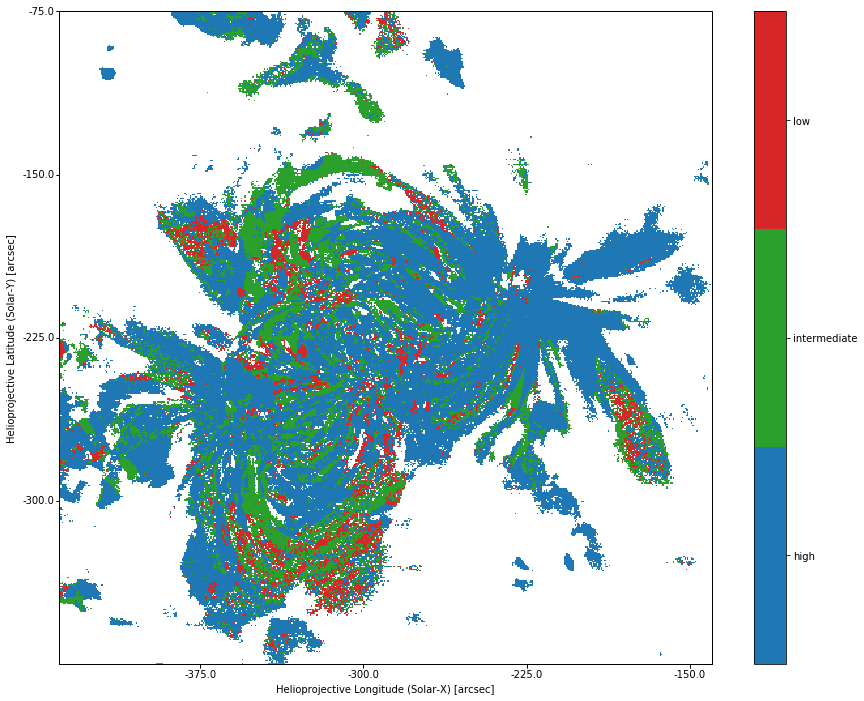

In [81]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca(projection=frequency_map_knn)
im = frequency_map_knn.plot(
    axes=ax,title=False,
    cmap=matplotlib.colors.ListedColormap(['C0','C2','C3'],N=3),
    vmin=-0.5,vmax=2.5)
fig.colorbar(im, ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),)
ax.grid(alpha=0)

## Comparing Methods

In [59]:
data_rf = frequency_map_random_forest.data[~np.isnan(frequency_map_random_forest.data)].flatten()
data_knn = frequency_map_knn.data[~np.isnan(frequency_map_knn.data)].flatten()
data_adaboost = frequency_map_adaboost.data[~np.isnan(frequency_map_adaboost.data)].flatten()

[Text(0,0,'Random Forest'), Text(0,0,'KNN'), Text(0,0,'Adaboost')]

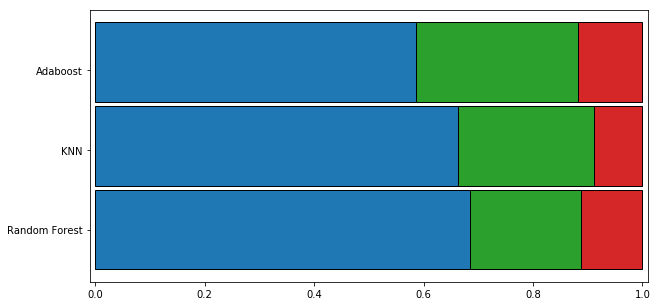

In [83]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
cmap=matplotlib.colors.ListedColormap(['C0','C2','C3'],N=3)
for i,d in enumerate([data_rf, data_knn, data_adaboost]):
    ax.barh(i*1.05,d[d == 0].shape[0]/d.shape[0],color=cmap.colors[0],height=1,edgecolor='k')
    ax.barh(i*1.05,d[d == 1].shape[0]/d.shape[0],left=d[d == 0].shape[0]/d.shape[0],color=cmap.colors[1],height=1,edgecolor='k')
    ax.barh(i*1.05,d[d == 2].shape[0]/d.shape[0],left=d[d != 2].shape[0]/d.shape[0],color=cmap.colors[2],height=1,edgecolor='k')
#Labels, Ticks, etc
ax.set_xlim(-0.01,1.01)
ax.set_yticks([0,1,2],)
ax.set_yticklabels(('Random Forest', 'KNN', 'Adaboost'))